# Read in the data

In [12]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [13]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [14]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [15]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [16]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [17]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [18]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [19]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [20]:
correlations = combined.corr()
correlations = correlations["sat_score"]

# Writing my Code Now

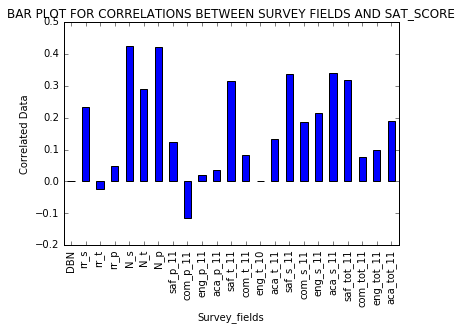

In [21]:
%matplotlib inline
correlations[survey_fields].plot.bar()
plt.xlabel("Survey_fields")
plt.ylabel("Correlated Data")
plt.title("BAR PLOT FOR CORRELATIONS BETWEEN SURVEY FIELDS AND SAT_SCORE")

### Shows a bar plot for all survey fields v/s sat_score

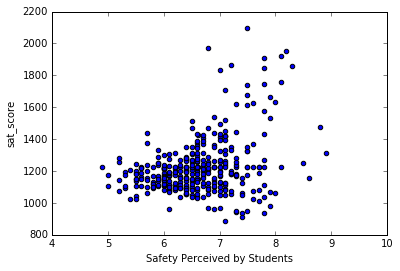

In [22]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel("Safety Perceived by Students")
plt.ylabel("sat_score")

##### From the above scatteeplot, we observe that a student safety value in the range of 5-8 is when the sat_scores are in majority. But, with increase in the safety value perceived by students between 7-8 proves a increase in the sat_score value as well

In [23]:
safety_score = combined.groupby('school_dist').agg(numpy.mean)
safety_score.reset_index(inplace=True)

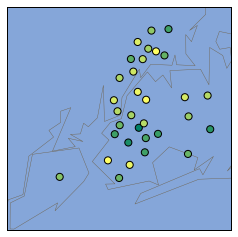

In [24]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = safety_score['lon'].tolist()
latitudes = safety_score['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon = True, c=safety_score['saf_s_11'], cmap = 'summer')
plt.show()

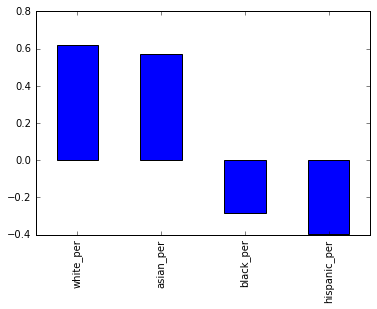

In [25]:
race_cols = ['white_per','asian_per','black_per','hispanic_per']
correlations[race_cols].plot.bar()

#### The above bar plot displays the sat_score by the different races available in the data sets. From the above graph, we observe that the White/Asian races have a positive high correlation with the SAT_SCORE, while the Black/Hispanics have a negative correlation. One thing to note is the Black race have a low corelation compared to other races.

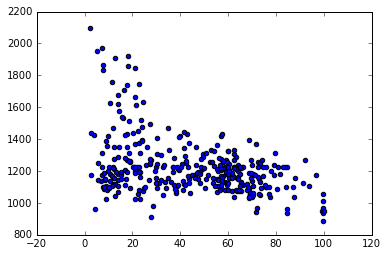

In [26]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])

#### From the above scatterplot, we observe that with low population percentage of hispanics, there is a high sat_score. But, with increase in the hispanic population percentage, we observe that the SAT_SCORE reach a plateau in the range of 1000-1400.

In [27]:
hispanic_high_schools = combined[combined["hispanic_per"] > 95]

In [28]:
hispanic_high_schools = combined[combined["hispanic_per"] < 10]
hispanic_high_schools = hispanic_high_schools[hispanic_high_schools['sat_score'] > 1800]

In [29]:
print(hispanic_high_schools['sat_score'])

37     2096.0
151    1969.0
187    1833.0
327    1868.0
356    1953.0
Name: sat_score, dtype: float64


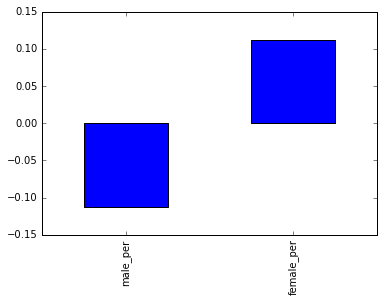

In [30]:
gender_col = ['male_per','female_per']
correlations[gender_col].plot.bar()

#### from the above bar plot, we observe that male students are negatively correlated with Sat_scores, while female students have positive correlations.

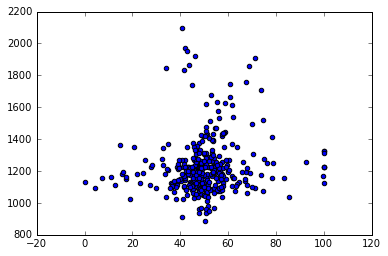

In [31]:
plt.scatter(combined['female_per'], combined['sat_score'])

#### A higher percentage of female students are in the area of 1000-1400 on the sat_score. Females percentages between 40-80 in schools have a higher sat_score

In [36]:
female_schools = combined[combined['female_per'] > 60]
female_schools = female_schools[female_schools['sat_score'] > 1700]

#### the school are in the main districts 01, 03, 25 which might be very affluent with greater white populations

In [43]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

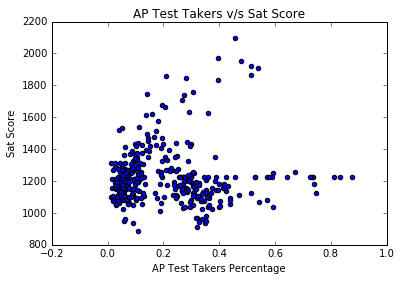

In [48]:
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.xlabel("AP Test Takers Percentage")
plt.ylabel("Sat Score")
plt.title("AP Test Takers v/s Sat Score")

#### From the above scatter plot, we observe students who have taken a higher number of 